# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [474]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [475]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [476]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,CLEAR BEER,TANK,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890
1,01002,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472
2,01003,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085
3,01005,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,4930.067934,4515.50,NaN,NaN,NaN,NaN,4459.9005
4,01010,CLEAR BEER,KEG ONE WAY,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,46.150597,7.15,NaN,NaN,NaN,NaN,40.8850


In [477]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          25002 non-null  object 
 1   ProductGroup      25002 non-null  object 
 2   PrimaryPack       25002 non-null  object 
 3   Country           25002 non-null  object 
 4   Year              25002 non-null  int64  
 5   Week              25002 non-null  int64  
 6   NumberWorkdays    25002 non-null  int64  
 7   AvgTemp           25002 non-null  float64
 8   AvgRain           25002 non-null  float64
 9   AvgSun            25002 non-null  float64
 10  IsLockdown        25002 non-null  bool   
 11  PdtHl             479 non-null    float64
 12  PrevWeekPdtHl1    449 non-null    float64
 13  BgtHl             20233 non-null  float64
 14  SalesHl           25002 non-null  float64
 15  PrevWeekSalesHl1  24456 non-null  float64
 16  PrevWeekSalesHl2  24253 non-null  float6

In [478]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,25002.000000,479.000000,449.000000,20233.000000,25002.000000,24456.000000,24253.000000,18458.000000,13749.000000,23161.000000
mean,2018.157387,25.786497,4.787257,10.362729,1.676177,4.890909,32.313421,20.110566,757.496843,620.624621,377.808018,380.386378,461.394173,420.646117,642.398067
std,1.530272,15.039761,0.494658,7.721815,1.648968,2.984937,59.760659,34.993695,1484.212328,1473.285981,943.515589,946.969143,1063.198647,920.020846,1408.082133
min,2016.000000,1.000000,2.000000,-8.278571,0.000000,0.142857,0.300000,0.300000,0.000251,0.000000,0.000000,0.000000,0.000000,0.000000,0.053200
25%,2017.000000,13.000000,5.000000,4.000000,0.471429,2.164286,3.045784,2.781457,58.403662,30.000000,25.200000,25.800000,36.000000,39.000000,39.999200
50%,2018.000000,25.000000,5.000000,10.178571,1.142857,4.707143,13.037634,7.666667,214.440000,121.200000,79.200000,80.000000,108.600000,110.000000,150.470900
75%,2019.000000,39.000000,5.000000,17.707143,2.364286,7.135165,33.846154,28.889304,658.311358,486.300000,334.900000,336.910200,418.500000,415.500000,533.663400
max,2021.000000,53.000000,5.000000,25.814286,7.957143,13.864286,318.814035,318.814035,14379.048541,17816.500000,13487.500000,13487.500000,13487.500000,11801.000000,15049.836100


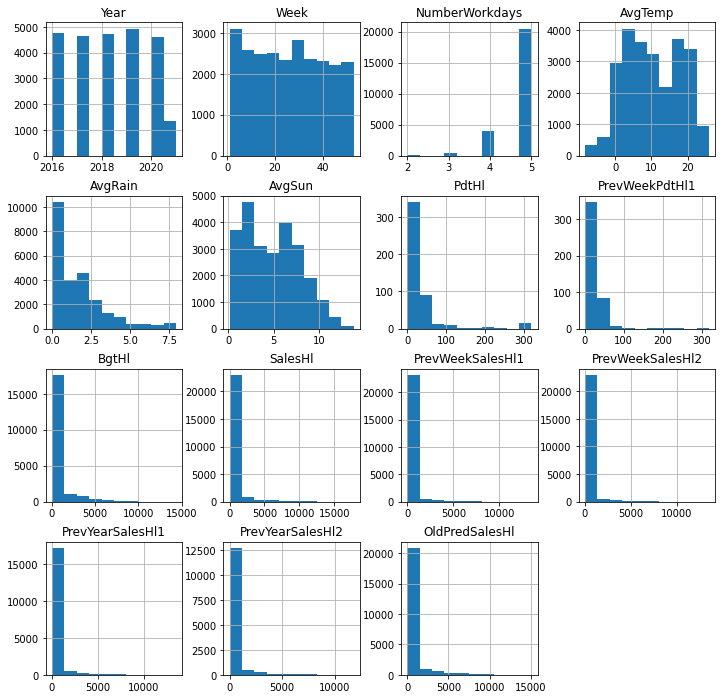

In [479]:
data.hist(figsize=[12,12])
plt.show()

<AxesSubplot:xlabel='Year,Week'>

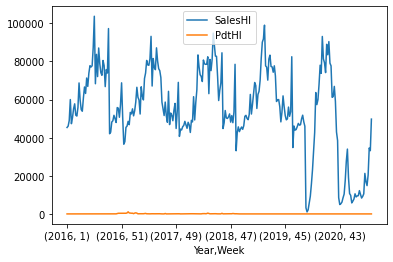

In [480]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl', 'PdtHl'])

<AxesSubplot:xlabel='Year,Week'>

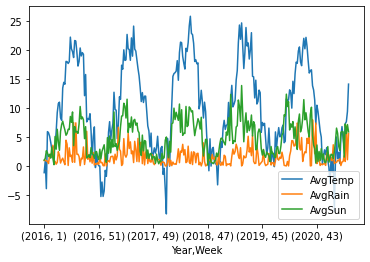

In [481]:
data.groupby(['Year','Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun'])

## Create X, y

In [482]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'BgtHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year'

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [483]:
#X = X.fillna(0)

## LabelEncoder

In [484]:
#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

X.SkuShort = LabelEncoder().fit_transform(X.SkuShort)
X.ProductGroup = LabelEncoder().fit_transform(X.ProductGroup)
X.PrimaryPack = LabelEncoder().fit_transform(X.PrimaryPack)
X.Country = LabelEncoder().fit_transform(X.Country)

# #round weather
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

X.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,1,3,0,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,0,0,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,0,0,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,0,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,NaN,NaN,NaN,NaN


## Imputer

In [485]:
# X = X.fillna(0)
# X = X.dropna(inplace=True)

si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)
si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X_imputer = pd.DataFrame(si.transform(X))
X_imputer.columns = X.columns
X_imputer.index = X.index
X = X_imputer

## Add AVG column

In [486]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

## Split train, test

In [487]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
24265,0.0,1.0,3.0,0.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,32.313421,20.110566,155.07,215.12,360.00,335.00,185.1,347.5,266.3
24266,1.0,1.0,0.0,0.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,32.313421,20.110566,57.45,64.65,66.45,60.45,61.0,63.4,62.3
24267,2.0,1.0,0.0,0.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,32.313421,20.110566,165.00,194.10,496.50,462.30,179.6,479.4,329.5
24268,3.0,1.0,0.0,0.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,32.313421,20.110566,280.50,382.00,628.50,757.00,331.2,692.8,512.0
24269,13.0,1.0,0.0,0.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,32.313421,20.110566,96.60,114.60,329.40,6.90,105.6,168.1,136.9


## Scaler

In [488]:
#scaler = MinMaxScaler() #0.8361
#scaler = MaxAbsScaler() #0.8335
scaler = StandardScaler() #0.8381

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Regressor

In [489]:
# param_grid = dict()
# #alpha=[1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001],fit_intercept=[True, False], verbose=[True, False], normalize=[True, False], precompute=[True, False], copy_X=[True, False], fit_path=[True, False], positive=[True, False], jitter=[True, False]
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [490]:
# Create linear regression object

#NOT model = ensemble.AdaBoostRegressor()
#tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
#model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
#model = linear_model.LinearRegression(copy_X=False, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Ridge(max_iter=1000, copy_X=False, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
#model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

#model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
#model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
#model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
#model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

#model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
#model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
#model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
#model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

#model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049


# hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
# mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
# rfModel = ensemble.RandomForestRegressor(random_state=0,n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=4)
# # knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)
# # sgdModel = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# # lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)

# estimators = [('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel), ('xgb', xgbModel)] #[('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel), ('xgb', xgbModel)]
# model = ensemble.VotingRegressor(estimators, weights=[1, 0.5, 0.5, 0.8], n_jobs=3) #[1, 0.5, 0.5, 0.8]

model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0) #0.8418
#model = LGBMRegressor() #0.8059

#AdaBoostRegressor
#GradientBoostingRegressor
#BaggingRegressor
#KNeighborsRegressor

# Train the model using the training sets
model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# errors = abs(y_pred - y_test.to_numpy())
# mape = 100 * np.mean(errors / y_test.to_numpy())
# accuracy = 100 - mape
# print('Accuracy = {:0.2f}%.'.format(accuracy))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))

# print(f'The number of iterations as selected by early stopping: {model.n_iter_}')
# print(f'The scores at each iteration on the training data: {model.train_score_}')
# print(f'The scores at each iteration on the held-out validation data: {model.validation_score_}')
# print(f'Boolean mask for the categorical features: {model.is_categorical_}')

#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829 (0.6246), 0.8377 (0.8027)
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8686 (0.8584), 0.8561 (0.8597)
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418


#all-trade
#VotingRegressor = 0. (0.), 0. (0.)

#0.8381

on-trade
Coefficient of determination: 0.8418
Maximum residual error: 1931.0000
Mean absolute percentage error regression loss: 3568659677590733.5000


ValueError: Unable to coerce to Series, length must be 1: given 737

## Model analysis

In [459]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10            99.2%          68.0%             -31.2%
     11            92.7%          88.7%              -4.0%
     12            93.5%          90.1%              -3.5%
     13            57.3%          64.4%               7.1%
     14            64.8%          92.3%              27.5%
     15            86.0%          87.0%               0.9%
     16            99.3%          81.2%             -18.2%
     17            94.1%          82.9%             -11.2%
     18            81.8%          91.8%               9.9%
     19            73.4%          88.3%              14.9%
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021          82.6%          98.4%              15.8%


In [460]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# X_labels = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_labels)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [461]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()
X_labels = X.columns.tolist()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

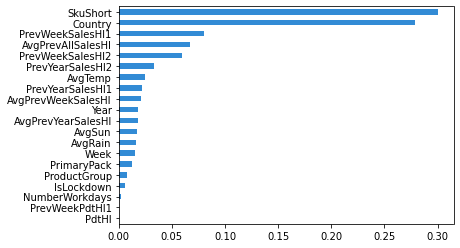

In [462]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [463]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [464]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [465]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [466]:
# shap.plots.force(shap_values[0])

In [467]:
# shap.plots.force(shap_values)

In [468]:
# shap.plots.scatter(shap_values, color=shap_values)

In [469]:
# shap.plots.bar(shap_values)

In [470]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [471]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [472]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [473]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363